## Style Transfer using VGG16

* `A Neural Algorithm of Artistic Style`, [arXiv:1508.06576](https://arxiv.org/abs/1508.06576)
* Leon A. Gatys, Alexander S. Ecker, and, Matthias Bethge


* `models/research/slim/nets`을 이용하여 만듦
* `image_size`를 input_image에 맞게 조절 (최대 이미지 길리 max_L=1024 로 고정)
* 원래 논문처럼 `average_pooling` 사용
* loss는 논문에 나온 그대로 사용 (조금 맘에 안들지만)
* hyperparameter들은 cs20 코드를 참조함

In [ ]:
#Connected google drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
#make data directory
!mkdir -p drive
!google-drive-ocamlfuse drive

In [1]:
#Setting
import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import tensorflow as tf
slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="1"

C:\Users\home\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Hyper Paremeters

In [2]:
input_data_dir = '../input_data/'
content_image_name = 'content.jpg'
style_image_name = 'style.jpg'
noise_ratio = 0.6 #초기 이미지에 noise를 섞기위한 paremeter
max_L = 1024 # 최대 이미지 크기
style_loss_weight = np.array([0.5, 1.0, 1.5, 3.0, 4.0]) #style layer마다 다른 loss weight 부여
content_weight = 0.0001 #loss 계산시, content loss에 대한 weight
stlye_weight = 1.0 #loss 계산시, style loss에 대한 weight
learning_rate = 0.1
max_steps = 1000
print_steps = 100

### Load a VGG-16 grahp

In [3]:
def vgg_16(inputs,
           reuse=False,
           scope='vgg_16'):
  """Oxford Net VGG 16-Layers version D Example
  
  My Note: This code is modified version of vgg_16 which is loacted on `models/research/slim/nets/vgg.py`
  * input단의 필요없는 paremeters 제거 및, fully layer 제거, avg_pooling 사용
      style transfer에서는 output이 필요없기 때문.
  Note: All the fully_connected layers have been transformed to conv2d layers.
        To use in classification mode, resize input to 224x224.

  Args:
    inputs: a tensor of size [batch_size, height, width, channels].
    reuse: whether or not the model is being reused.
    scope: Optional scope for the variables.

  Returns:
    net: the output of the logits layer (if num_classes is a non-zero integer),
      or the input to the logits layer (if num_classes is 0 or None).
    end_points: a dict of tensors with intermediate activations.
  """
  with tf.variable_scope(scope, 'vgg_16', [inputs], reuse=reuse) as sc:
    end_points_collection = sc.original_name_scope + '_end_points'
    with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.avg_pool2d],
                        outputs_collections=end_points_collection):
      
      net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
      net = slim.avg_pool2d(net, [2, 2], scope='pool1')
      net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
      net = slim.avg_pool2d(net, [2, 2], scope='pool2')
      net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
      net = slim.avg_pool2d(net, [2, 2], scope='pool3')
      net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
      net = slim.avg_pool2d(net, [2, 2], scope='pool4')
      net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
      net = slim.avg_pool2d(net, [2, 2], scope='pool5')

      end_points = slim.utils.convert_collection_to_dict(end_points_collection)

      return net, end_points

## Read content and style image

In [4]:
content_image_ = Image.open(os.path.join(input_data_dir, content_image_name))
style_image_ = Image.open(os.path.join(input_data_dir, style_image_name))

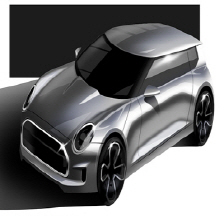

In [5]:
style_image_

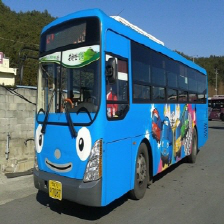

In [6]:
content_image_

In [7]:
#image의 크기가 max_L을 넘어갈 경우, downsizing
def image_resize_with_upper_bound(image, max_L=max_L): 
  """Resize images, 
  
  Args:
    image: PIL image format
    max_L: upper bound of the image size
    
  Returns:
    image: resized image with PIL format
    h: resized height
    w: resized width
    """
  w, h = image.size 
  if np.max(np.array([h, w])) > max_L: 
    if h < w: 
      h = int(max_L * h / w) 
      w = max_L
    else:
      w = int(max_L * w / h)
      h = max_L
  image = image.resize((h, w))
  
  return image, h, w

In [8]:
#image, h, w 추출
content_image_, content_image_w, content_image_h = image_resize_with_upper_bound(content_image_)
style_image_w, style_image_h = style_image_.size

In [9]:
#Setting placeholder, inputs: a tensor of size [batch_size, height, width, channels].
content_image_p = tf.placeholder(dtype=tf.float32, shape=[1, content_image_h, content_image_w, 3])
style_image_p = tf.placeholder(dtype=tf.float32, shape=[1, style_image_h, style_image_w, 3])

# content_image, style_image를 tf.Variable로 바꾸기 위해 tf.placeholder와 같은 shape의 zero Tensor를 만듦
content_image = tf.get_variable(shape=[1, content_image_h, content_image_w, 3],
                                initializer=tf.zeros_initializer(), name='content_image')
style_image = tf.get_variable(shape=[1, style_image_h, style_image_w, 3],
                             initializer=tf.zeros_initializer(), name='style_image')
generated_image = tf.get_variable(shape=[1, content_image_h, content_image_w, 3],
                                 initializer=tf.random_uniform_initializer(minval=-0.2, maxval=0.2), name='generated_image')

# tf.placeholder를 tf.Variable로 바꿈
content_image_op = content_image.assign(content_image_p)
style_image_op = style_image.assign(style_image_p)

#generated image에 random noise를 섞음
generated_image_op = generated_image.assign(generated_image * noise_ratio + \
                                            content_image_p * (1.0 - noise_ratio))

# generated_image는 매 update 후에 [-1, 1] 사이로 clipping
generated_image_clipping = generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=-1.0, clip_value_max=1.0))

In [10]:
with tf.variable_scope('', reuse=tf.AUTO_REUSE) as scope:
    _, feature_maps_c = vgg_16(inputs=content_image)
    _, feature_maps_s = vgg_16(inputs=style_image)
    _, feature_maps_g = vgg_16(inputs=generated_image)

In [11]:
with tf.Session() as sess:
  writer = tf.summary.FileWriter("./graphs/02_style_transfer", sess.graph)
  writer.close()

## Build a Model

### collecte feature maps

* content layers
  * `conv4_2`: key name -> 'vgg16/vgg_16/conv4/conv4_2'
* style layers
  * `conv1_1`: key name -> 'vgg16/vgg_16/conv1/conv1_1'
  * `conv2_1`: key name -> 'vgg16/vgg_16/conv2/conv2_1'
  * `conv3_1`: key name -> 'vgg16/vgg_16/conv3/conv3_1'
  * `conv4_1`: key name -> 'vgg16/vgg_16/conv4/conv4_1'
  * `conv5_1`: key name -> 'vgg16/vgg_16/conv5/conv5_1'

In [12]:
content_layers = feature_maps_c['vgg_16/conv4/conv4_2']
style_layers = [feature_maps_s['vgg_16/conv1/conv1_1'],
                feature_maps_s['vgg_16/conv2/conv2_1'],
                feature_maps_s['vgg_16/conv3/conv3_1'],
                feature_maps_s['vgg_16/conv4/conv4_1'],
                feature_maps_s['vgg_16/conv5/conv5_1']]
generated_layers = [feature_maps_g['vgg_16/conv4/conv4_2'],
                    feature_maps_g['vgg_16/conv1/conv1_1'],
                    feature_maps_g['vgg_16/conv2/conv2_1'],
                    feature_maps_g['vgg_16/conv3/conv3_1'],
                    feature_maps_g['vgg_16/conv4/conv4_1'],
                    feature_maps_g['vgg_16/conv5/conv5_1']]

## Define Loss

In [13]:
#Content Loss
def content_loss(P, F, scope):
  """Calculate the content loss function between
  the feature maps of content image and generated image.
  
  Args:
    P: the feature maps of the content image
    F: the feature maps of the generated image
    scope: scope
    
  Returns:
    loss: content loss (mean squared loss)
  """
  # 여기를 직접 채워 넣으시면 됩니다.
  loss = 0.5 * tf.reduce_sum(tf.square(P - F)) * 0.5
  return loss

In [14]:
#Style Loss
def style_loss(style_layers, generated_layers, scope):
    def _style_loss_one_layer(feature_map_s, feature_map_g):
        """Calculate the style loss for one layer.
    
    Args:
      feature_map_s: the feature map of the style image
        - G: the gram matrix of the feature_map_s
      feature_map_g: the feature map of the generated image
        - A: the gram matrix of the feature_map_g
      
    Returns:
      loss: style loss for one layer (mean squared loss)
    """
        #assert feature_map_s.shape == feature_map_g.shape
        
        G = _gram_matrix(feature_map_s)
        A = _gram_matrix(feature_map_g)
        _, h, w, c = feature_map_g.shape.as_list()
        #tensor.get_shape().as_list() -> To get the shape as a list of ints
        loss = tf.reduce_sum(tf.square(G - A)) / (4. * (h*w)**2 * c**2)
        return loss

    def _gram_matrix(feature_map):
        """Calculate the gram matrix for the feature map

        Args:
          feature_map: 4-rank Tensor [1, height, width, channels]
            - F = 2-rank Tensor [h * w, channels]

        Returns:
          gram_matrix: 2-rank Tensor [c, c] (F.transpose x F)
        """
        F = tf.squeeze(feature_map, axis=0)
        h, w, c = F.shape
        F = tf.reshape(F, shape=[h*w,c])
        gram = tf.matmul(tf.transpose(F), F)
        return gram
    
    assert len(style_layers) == len(generated_layers)
    loss = 0.0
    for i in range(len(style_layers)):
        loss_one = _style_loss_one_layer(style_layers[i], generated_layers[i])
        loss += loss_one * style_loss_weight[i]
        
    return loss * 0.25

In [15]:
#Total loss
loss_c = content_loss(content_layers, generated_layers[0], scope='content_loss')
loss_s = style_loss(style_layers, generated_layers[1:], scope='style_loss')

with tf.variable_scope('total_loss'):
    total_loss = loss_c + loss_s

## Define a optimizer

In [16]:
opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = opt.minimize(total_loss, var_list= generated_image)

## Preprocessing a image

In [17]:
def image_preprocessing(image):
    """image preprocessing
    transform image pixel value: int [0, 255] -> float [-1.0, 1.0]

      Args:
        image: PIL image format
  
      Returns:
        image: float type numpy array with shape [1, image_h, image_w, 3] which is in [-1, 1]
    """
    image = np.asarray(image) / 255 # image in [0, 1]
    image = (image-0.5) * 2 #image in [-0.5, 0.5] -> [-1, 1]
    
    image = np.expand_dims(image, axis=0)
    return image

In [18]:
def print_image(image):
    """print iamge
    
    Args:
        image: 4-rank np.array[1, h, w, 3]
    """
    print_image = np.squeeze(image, axis=0)
    print_image = np.clip(print_image, -1.0, 1.0)
    print_image = (print_image +1) * 0.5
    
    plt.axis('off')
    plt.imshow(print_image)
    plt.show()

In [19]:
content_image_ = image_preprocessing(content_image_)
style_image_ =image_preprocessing(style_image_)

## Restore VGG weight using `tf.saver.restore`

### Download the VGG16 checkpoint: 

```
$ CHECKPOINT_DIR='C:\Users\home\cs20_v2\input_data\checkpoints'
$ mkdir ${CHECKPOINT_DIR}
$ cd ${CHECKPOINT_DIR}
$ wget http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz
$ tar -xvf vgg_16_2016_08_28.tar.gz
$ rm vgg_16_2016_08_28.tar.gz
```

In [20]:
#load model's weight
v = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'vgg_16')

In [21]:
checkpoint_path =  os.path.join("C:/Users/home/cs20_v2/input_data/checkpoints/vgg_16.ckpt")

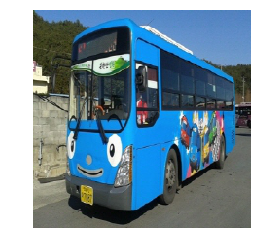

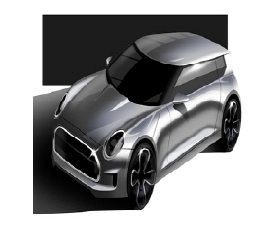

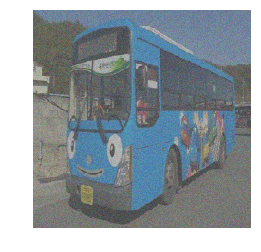

INFO:tensorflow:Restoring parameters from C:/Users/home/cs20_v2/input_data/checkpoints/vgg_16.ckpt


KeyboardInterrupt: 

In [22]:
saver = tf.train.Saver(var_list = v) #Saves and restores variables.

with tf.Session(config=sess_config) as sess:
    sess.run(tf.global_variables_initializer())
    # content_image_와 style_image_를 tf.placeholder에 넣고 tf.Variable로 assign
    sess.run([content_image_op, style_image_op, generated_image_op],
            feed_dict={content_image_p:content_image_, style_image_p: style_image_})
    
    _, generated_image_ = sess.run([generated_image_clipping, generated_image])
    
    print_image(content_image_)
    print_image(style_image_)
    print_image(generated_image_)
    
    # use saver object to load variables from the saved model
    saver.restore(sess, checkpoint_path)
    
    start_time = time.time()
    for step in range(max_steps):
        _, loss_, loss_c_, loss_s_, _, generated_image_ = \
            sess.run([train_op, total_loss, loss_c, loss_s, generated_image_clipping, generated_image])
        if (step+1) % print_steps == 0:
          duration = time.time() - start_time
          start_time = time.time()
          print("step: {}  total_loss: {}  loss_c: {}  loss_s: {}  duration: {}".format((step+1), loss_, loss_c_, loss_s_, duration))
          print_image(generated_image_)

    print('training done!')

In [ ]:
def save_image(image, content_image_name, style_image_name):
  """print image
  
  Args:
    image: 4-rank np.array [1, h, w, 3]
    content_image_name: (string) filename of content image
    style_image_name: (string) filename of style image
  """
  save_image = np.squeeze(image, axis=0)
  save_image = np.clip(save_image, -1.0, 1.0)
  save_image += 1.0
  save_image /= 2.0

  save_image = Image.fromarray(np.uint8(save_image*255))
  filename = os.path.splitext(os.path.basename(content_image_name))[0] + '_'
  filename += os.path.splitext(os.path.basename(style_image_name))[0] + '.jpg'
  save_image.save(filename)

In [ ]:
save_image(generated_image_, content_image_name, style_image_name)